# Explanation

Understanding all the fundamentals behind how standard deep neural networks work is a critical starting point to diving into the rest of the repository and the remaining papers.

There are many great resources online to learn about these fundamentals effectively. My personal favorites are:
- 3blue1brown's neural networks series - [Neural networks](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=lNICwc8Q1g5AFRT1)
- Andrej Karpathy's introduction - [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)

I won't go over all the essentials here since these resources cover them well - but I do want to highlight the importance of a few key intuitions that will continually appear throughout these papers, which must be understood very well.

It's critical to understand the model of how gradients flow through the neural network during back-propagation, and what determines how gradients are propagated from later to earlier neurons. These gradient flows are important for understanding many of the optimization & regularization methods discussed later, as well as for understanding the issues and solutions related to many architectures like RNNs and LSTMs.

# Implementation

I made the implementation following Andrej Karpathy's micrograd tutorial, which is the best resource I've found for building all the intuitions of how feed-forward networks and backpropagation work:

- [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)

In [ ]:
import math
import random

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * - 1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [ ]:
class Neuron:
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act # TODO: support other act

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # last layer should not use relu
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(1337)
random.seed(1337)

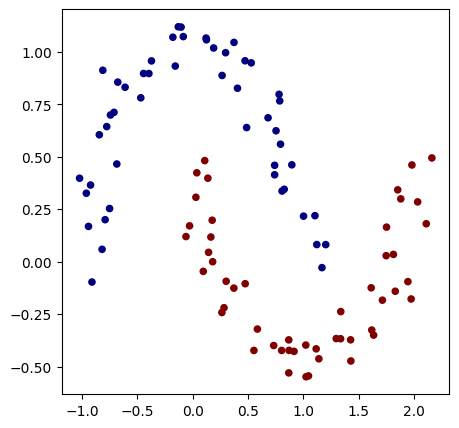

In [4]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [8]:
model = MLP(2, [16, 16, 1])
print("num parameters", len(model.parameters()))

num parameters 337


In [6]:
def loss(batch_size=None):
    # implement batching for sgd with Xb, yb
    if batch_size is None:
        Xb, yb = X, y
    else:
        # get batch_size number of indices of random elements
        ri = np.random.permutation(X.shape[0])[:batch_size]
        # get batch_size random elements
        Xb, yb = X[ri], y[ri]
    # create coordinate pairs of Value
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1.0 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4 # how much to penalize
    reg_loss = alpha * sum((p*p for p in model.parameters())) # compute penalty for L^2 norm on parameters
    total_loss = data_loss + reg_loss # add penalty (prefer lower weight/bias values)

    # accuracy
    accuracy = [1.0 if (yi > 0) == (scorei.data > 0) else 0.0 for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [9]:
# optimization
for k in range(100):
    # forward pass
    total_loss, acc = loss()

    # backward pass
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()

    # update
    learning_rate = 1.0 - 0.9*k/100 # decrease learning rate over time
    for p in model.parameters():
        p.data -= learning_rate * p.grad # increment in negative grad direction

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.2606891092765604, accuracy 24.0%
step 1 loss 0.9442463519767779, accuracy 78.0%
step 2 loss 0.41078667004561353, accuracy 83.0%
step 3 loss 0.3379238727847242, accuracy 87.0%
step 4 loss 0.2908982365179929, accuracy 88.0%
step 5 loss 0.25812466062214995, accuracy 91.0%
step 6 loss 0.24635683434457756, accuracy 89.0%
step 7 loss 0.35128563599764, accuracy 90.0%
step 8 loss 0.5500432035581851, accuracy 82.0%
step 9 loss 0.4200738714474908, accuracy 86.0%
step 10 loss 0.28142665110081916, accuracy 87.0%
step 11 loss 0.22280628266127722, accuracy 89.0%
step 12 loss 0.18847340669400542, accuracy 92.0%
step 13 loss 0.2020852225794971, accuracy 92.0%
step 14 loss 0.20693945579361875, accuracy 92.0%
step 15 loss 0.24853999671926388, accuracy 90.0%
step 16 loss 0.16149171548914237, accuracy 92.0%
step 17 loss 0.15300691563647678, accuracy 93.0%
step 18 loss 0.15574154514031546, accuracy 92.0%
step 19 loss 0.15819656536268298, accuracy 94.0%
step 20 loss 0.18569575058108678, accura

In [ ]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())